In [1]:
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/V05_ChargeSplit_Final_8Vars'
n_epochs = 125
mkdir_p(path_tosave)
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DPhill_SS", "DeltaR_min_lep_bjet77", "DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
#samples, feature_names, class_names, class_no = load_input_file('data/sstt_multiclass_background_V03.h5', features_to_ignore)
samples, feature_names, class_names, class_no = load_input_file('data/V05_sstt_Data.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DPhill_SS
Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 21 features on the dataset 10 features were loaded: 

HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  253953
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Class 9  :  0
Class 10  :  425286
Dataset contains 679239 Signal events and 1425994 Background events.


In [3]:
Number = np.squeeze((input_features[:,-1]).astype(int))
feature_names = feature_names[:-1]
input_features = input_features[:,:-1]

In [4]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Other' 'Diboson' 'Fakes'
 'signaltbartbar']
[ 0  1  2  3  4  5  6  7  8 10]


In [5]:
# Find total_charge index
i = 0
for feature in feature_names:
    if feature == 'total_charge':
        total_charge_idx = i
    i += 1
print("Found", feature_names[total_charge_idx], "at index", total_charge_idx)

# Drop out total charge in the Inputlist
total_charge = input_features[:,total_charge_idx]
input_features = np.delete(input_features, total_charge_idx, 1)
feature_names.remove('total_charge')

Found total_charge at index 7


In [6]:
# True -> 2 Positiv | False -> 2 Negative
boolean_charge = total_charge
boolean_charge[boolean_charge == 254] = -2

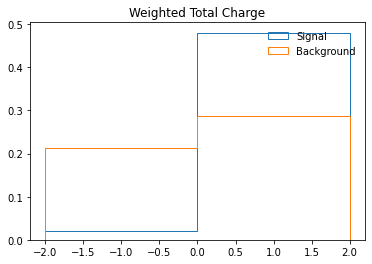

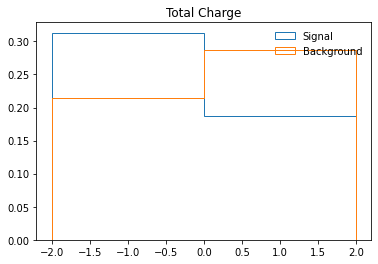

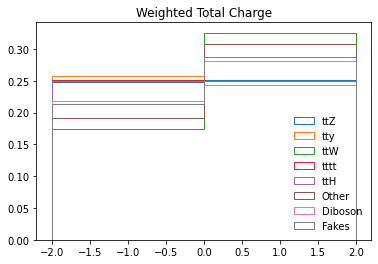

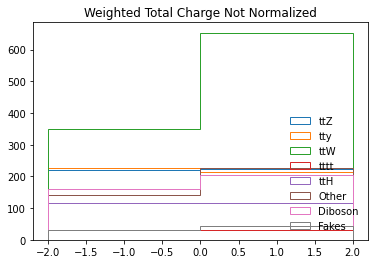

In [7]:
plt.title(str("Weighted Total Charge"))
plt.hist(boolean_charge[targets==1], bins=2, range=(-2, 2), weights=weights[targets==1], histtype='step', label='Signal', density=True)
plt.hist(boolean_charge[targets==0], bins=2, range=(-2, 2), weights=weights[targets==0], histtype='step', label='Background', density=True)
plt.legend(frameon=False)
plt.savefig(path_tosave + '/Charge_Split_Weighted.png')
plt.show()

plt.title(str("Total Charge"))
plt.hist(boolean_charge[targets==1], bins=2, range=(-2, 2), histtype='step', label='Signal', density=True)
plt.hist(boolean_charge[targets==0], bins=2, range=(-2, 2), histtype='step', label='Background', density=True)
plt.legend(frameon=False)
plt.savefig(path_tosave + '/Charge_Split.png')
plt.show()

plt.title(str("Weighted Total Charge"))
for i in range(class_no.shape[0]):
    if i == 0:
        continue
    if i == 9:
        continue
    plt.hist(boolean_charge[class_labels==class_no[i]], bins=2, range=(-2, 2), weights=weights[class_labels==class_no[i]], histtype='step', density=True, label=class_names[i])
plt.legend(frameon=False, loc='lower right')
plt.savefig(path_tosave + '/Charge_Split_Background_Weighted_Normalized.png')
plt.show()

plt.title(str("Weighted Total Charge Not Normalized"))
for i in range(class_no.shape[0]):
    if i == 0:
        continue
    if i == 9:
        continue
    plt.hist(boolean_charge[class_labels==class_no[i]], bins=2, range=(-2, 2), weights=weights[class_labels==class_no[i]], histtype='step', label=class_names[i])
plt.legend(frameon=False, loc='lower right')
plt.savefig(path_tosave + '/Charge_Split_Background_Weighted.png')
plt.show()

In [8]:
#Scaling weights before splitting into ++ and -- is probably wrong approach and unfair !!!!
#ScaleWeights(targets,weights)

#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)
pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

In [9]:
for i in range(input_scaled.shape[1]):
    max_val = input_scaled[:,i].max()
    min_val = input_scaled[:,i].min()
    plt.title(str(feature_names[i]))
    cqu = plt.hist(input_scaled[:,i][targets==1], bins=40, weights=weights[targets==1], range=(min_val, max_val), histtype='step', label='Signal', density=True)
    cuu = plt.hist(input_scaled[:,i][targets==0], bins=40, weights=weights[targets==0], range=(min_val, max_val), histtype='step', label='Background', density=True)
    plt.legend(frameon=False)
    save_name = path_tosave + "/Input_Feature_" + str(i) + ".png"
    plt.savefig(save_name)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [10]:
#Split into ++/pos and --/neg

# ++
input_scaled_pos = input_scaled[boolean_charge > 0]
targets_pos = targets[boolean_charge > 0]
weights_pos = weights[boolean_charge > 0]
class_labels_pos = class_labels[boolean_charge > 0]
Number_pos = Number[boolean_charge > 0]
# --
input_scaled_neg = input_scaled[boolean_charge < 0]
targets_neg = targets[boolean_charge < 0]
weights_neg = weights[boolean_charge < 0]
class_labels_neg = class_labels[boolean_charge < 0]
Number_neg = Number[boolean_charge < 0]

In [11]:
print("Ratio of Signal wrt to xs for ++ events: ", np.round(100 * weights_pos[targets_pos==1].sum() / weights_pos.sum(),3),"%")
print("Ratio of Signal wrt to xs for -- events: ", np.round(100 * weights_neg[targets_neg==1].sum() / weights_neg.sum(),3),"%")

Ratio of Signal wrt to xs for ++ events:  40.269 %
Ratio of Signal wrt to xs for -- events:  3.618 %


In [12]:
weights_pos_noScaling = np.copy(weights_pos)
weights_neg_noScaling = np.copy(weights_neg)
ScaleWeights(targets_pos,weights_pos)
ScaleWeights(targets_neg,weights_neg)


======Weight Statistic========================================
Weights::        W(1)=1152.66, W(0)=1709.75
Scaled weights:: W(1)=535230, W(0)=535230

======Weight Statistic========================================
Weights::        W(1)=47.8217, W(0)=1273.94
Scaled weights:: W(1)=517386, W(0)=517386


In [13]:
#Preprocess
odd_pos, even_pos = Fold_Odd_Even(input_scaled_pos, targets_pos, weights_pos, class_labels_pos, Number_pos)
odd_neg, even_neg = Fold_Odd_Even(input_scaled_neg, targets_neg, weights_neg, class_labels_neg, Number_neg)
input_shape = odd_pos[0].shape[1]
batch_size = 20000

# ++ Model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9     

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


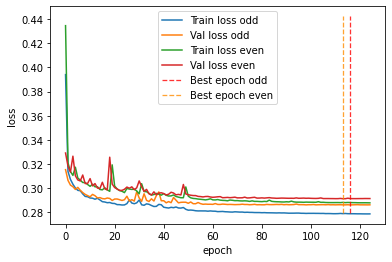

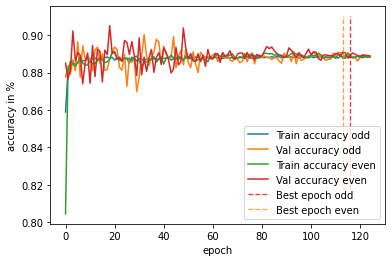

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_odd_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/weights_odd_pos.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_even_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/weights_even_pos.h5


In [14]:
hist_odd_pos, model_odd_pos, hist_even_pos, model_even_pos = Train_Odd_Even(odd_pos, even_pos, n_epochs = n_epochs, batch_size = batch_size)
history_list_pos = [hist_odd_pos, hist_even_pos]
Plot_Metrics_KFold(history_list_pos, path_tosave, "Pos_Models_")
Save_Model(model_odd_pos, path_tosave, "_odd_pos")
Save_Model(model_even_pos, path_tosave, "_even_pos")

# -- Model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

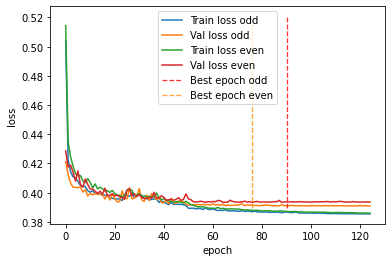

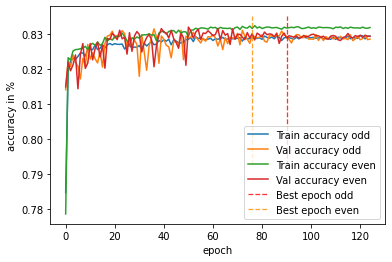

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_odd_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/weights_odd_neg.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_even_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/weights_even_neg.h5


In [15]:
hist_odd_neg, model_odd_neg, hist_even_neg, model_even_neg = Train_Odd_Even(odd_neg, even_neg, n_epochs = n_epochs, batch_size = batch_size)
history_list_neg = [hist_odd_neg, hist_even_neg]
Plot_Metrics_KFold(history_list_neg, path_tosave, "Neg_Models_")
Save_Model(model_odd_neg, path_tosave, "_odd_neg")
Save_Model(model_even_neg, path_tosave, "_even_neg")

# Evaluation

In [16]:
#Recreate Dataset without the weight scaling
odd_pos, even_pos = Fold_Odd_Even(input_scaled_pos, targets_pos, weights_pos_noScaling, class_labels_pos, Number_pos)
odd_neg, even_neg = Fold_Odd_Even(input_scaled_neg, targets_neg, weights_neg_noScaling, class_labels_neg, Number_neg)

In [17]:
model_odd_neg = Load_Model(path_tosave, name="_odd_neg")
model_even_neg = Load_Model(path_tosave, name="_even_neg")
model_odd_pos = Load_Model(path_tosave, name="_odd_pos")
model_even_pos = Load_Model(path_tosave, name="_even_pos")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_odd_neg.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/weights_odd_neg.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_even_neg.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/weights_even_neg.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_odd_pos.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/weights_odd_pos.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Final_8Vars/architecture_even_pos.json, /mnt

In [18]:
pred1 = model_even_pos.predict(odd_pos[0])
pred2 = model_odd_pos.predict(even_pos[0])
pred3 = model_even_neg.predict(odd_neg[0])
pred4 = model_odd_neg.predict(even_neg[0])

truth1 = odd_pos[1]
truth2 = even_pos[1]
truth3 = odd_neg[1]
truth4 = even_neg[1]

weights1 = odd_pos[2]
weights2 = even_pos[2]
weights3 = odd_neg[2]
weights4 = even_neg[2]

pred = np.concatenate([pred1, pred2, pred3, pred4])
truth = np.concatenate([truth1, truth2, truth3, truth4])
weights = np.concatenate([weights1, weights2, weights3, weights4])

In [19]:
fpr1, tpr1, thr1 = roc_curve(truth1, pred1, sample_weight=weights1)
fpr2, tpr2, thr2 = roc_curve(truth2, pred2, sample_weight=weights2)
fpr3, tpr3, thr3 = roc_curve(truth3, pred3, sample_weight=weights3)
fpr4, tpr4, thr4 = roc_curve(truth4, pred4, sample_weight=weights4)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

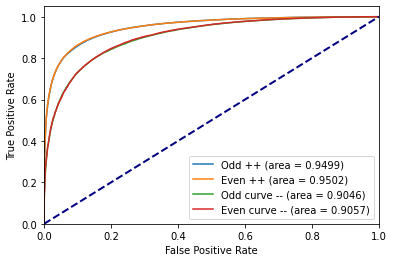

In [20]:
plt.plot(fpr1, tpr1 ,label='Odd ++ (area = {:.4f})'.format(roc_auc1))
plt.plot(fpr2, tpr2 ,label='Even ++ (area = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3 ,label='Odd curve -- (area = {:.4f})'.format(roc_auc3))
plt.plot(fpr4, tpr4 ,label='Even curve -- (area = {:.4f})'.format(roc_auc4))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(path_tosave + "/ROC-Curve-Odd-Even.png")
plt.show()

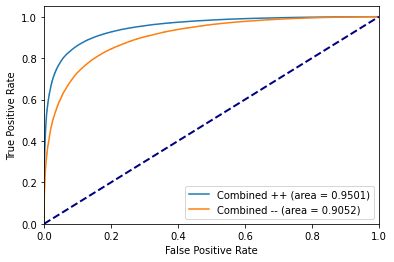

In [21]:
pred_pos = np.concatenate([pred1, pred2])
truth_pos = np.concatenate([truth1, truth2])
weights_pos = np.concatenate([weights1, weights2])
pred_neg = np.concatenate([pred3, pred4])
truth_neg = np.concatenate([truth3, truth4])
weights_neg = np.concatenate([weights3, weights4])

fpr_pos, tpr_pos, thr_pos = roc_curve(truth_pos, pred_pos, sample_weight=weights_pos)
fpr_neg, tpr_neg, thr_neg = roc_curve(truth_neg, pred_neg, sample_weight=weights_neg)

roc_auc_pos = auc(fpr_pos, tpr_pos)
roc_auc_neg = auc(fpr_neg, tpr_neg)

plt.plot(fpr_pos, tpr_pos ,label='Combined ++ (area = {:.4f})'.format(roc_auc_pos))
plt.plot(fpr_neg, tpr_neg ,label='Combined -- (area = {:.4f})'.format(roc_auc_neg))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(path_tosave + "/ROC-Curve-Combined.png")
plt.show()

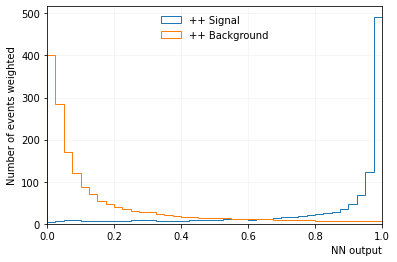

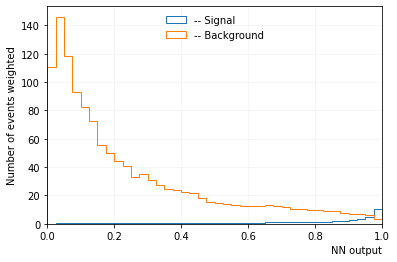

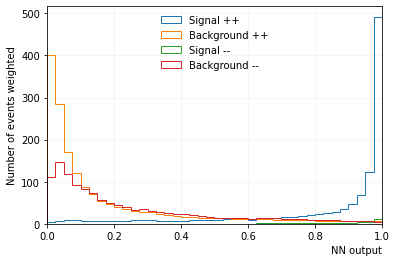

In [22]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_pos[:,0][truth_pos==1],label = "++ Signal", **histargs, weights=weights_pos[truth_pos==1])
plt.hist(pred_pos[:,0][truth_pos==0],label = "++ Background", **histargs, weights=weights_pos[truth_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.savefig(path_tosave + "/Pos-NN-Output-Weighted.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_neg[:,0][truth_neg==1],label = "-- Signal", **histargs, weights=weights_neg[truth_neg==1])
plt.hist(pred_neg[:,0][truth_neg==0],label = "-- Background", **histargs, weights=weights_neg[truth_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.savefig(path_tosave + "/Neg-NN-Output-Weighted.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events weighted")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_pos[:,0][truth_pos==1],label = "Signal ++ ", **histargs, weights=weights_pos[truth_pos==1])
plt.hist(pred_pos[:,0][truth_pos==0],label = "Background ++", **histargs, weights=weights_pos[truth_pos==0])
plt.hist(pred_neg[:,0][truth_neg==1],label = "Signal --", **histargs, weights=weights_neg[truth_neg==1])
plt.hist(pred_neg[:,0][truth_neg==0],label = "Background --", **histargs, weights=weights_neg[truth_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.savefig(path_tosave + "/Combined-NN-Output-Weighted.png")
plt.show()

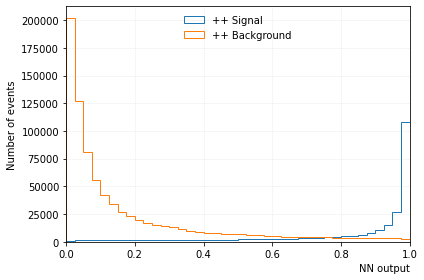

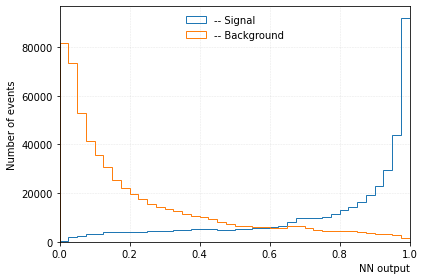

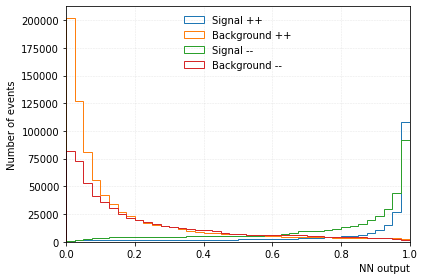

In [24]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_pos[:,0][truth_pos==1],label = "++ Signal", **histargs)
plt.hist(pred_pos[:,0][truth_pos==0],label = "++ Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig(path_tosave + "/Pos-NN-Output.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_neg[:,0][truth_neg==1],label = "-- Signal", **histargs)
plt.hist(pred_neg[:,0][truth_neg==0],label = "-- Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig(path_tosave + "/Neg-NN-Output.png")
plt.show()

fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Number of events")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_pos[:,0][truth_pos==1],label = "Signal ++ ", **histargs)
plt.hist(pred_pos[:,0][truth_pos==0],label = "Background ++", **histargs)
plt.hist(pred_neg[:,0][truth_neg==1],label = "Signal --", **histargs)
plt.hist(pred_neg[:,0][truth_neg==0],label = "Background --", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.tight_layout()
plt.savefig(path_tosave + "/Combined-NN-Output.png")
plt.show()